<a href="https://colab.research.google.com/github/trajinthan/Classification_of_-Anomaliesin_Gastrointestinal_Tract-/blob/master/Classification_of_Anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [0]:
import tensorflow as tf
import keras
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.applications import ResNet50


from skimage.transform import resize
from sklearn.model_selection import train_test_split
from __future__ import absolute_import, division, print_function, unicode_literals




Using TensorFlow backend.


**Downloading Dataset and storing it in on the machine**

In [0]:
_URL = 'https://datasets.simula.no/kvasir/data/kvasir-dataset.zip'


path_to_zip = tf.keras.utils.get_file('kvasir-dataset.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'kvasir-dataset')

1236213760/1236208343 [==============================] - 116s 0us/step


**Defining the categories**

In [0]:
categories = ["dyed-lifted-polyps","dyed-resection-margins","esophagitis","normal-cecum","normal-pylorus","normal-z-line","polyps","ulcerative-colitis"]

In [0]:
fnames=[]
for category in categories:
  image_folder = os.path.join(PATH,category)
  file_names = os.listdir(image_folder)
  full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
  fnames.append(full_path)
print('length for each category:', [len(f) for f in fnames])

length for each category: [500, 500, 500, 500, 500, 500, 500, 500]


In [0]:
images = []
for names in fnames:
  one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
  images.append(one_category_images)
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [500, 500, 500, 500, 500, 500, 500, 500]


In [0]:
def cvtRGB(img):
  return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

**Show sample image for each category (As we can see images are in RGB format)**

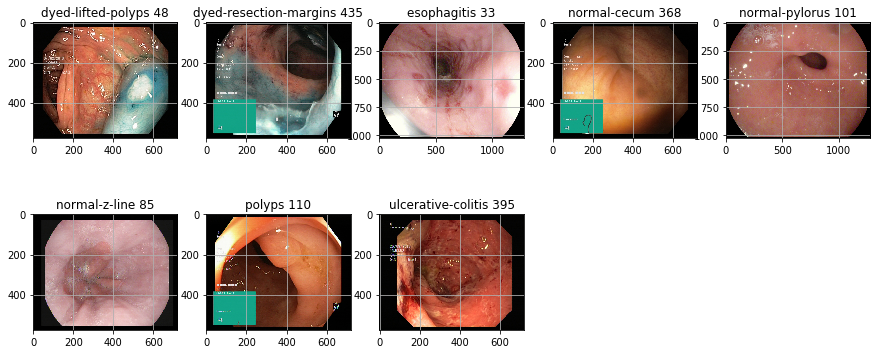

In [0]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
  plt.subplot(3,5,i+1)
  idx = np.random.randint(len(imgs))
  plt.imshow(cvtRGB(imgs[idx]))
  plt.grid('off')
  plt.title(categories[i]+' '+str(idx))
plt.show()

**RESIZING IMAGES**

In [0]:
img_width, img_height = 150, 150

resized_images = []
for i,imgs in enumerate(images):
  resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])
img1=resized_images[3][457]
img1.shape

(150, 150, 3)

**Splitting data into 90% train data and 10% testing data**

In [0]:
train_images = []
test_images = []
for imgs in resized_images:
  train, test = train_test_split(imgs, train_size=0.9, test_size=0.1)
  train_images.append(train)
  test_images.append(test)

In [0]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
  if i is 0:
    train_categories[:len_train_images[i]] = i
  else:
    train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_test_images = [len(imgs) for imgs in test_images]
print(len_test_images)
print('sum of test images:', np.sum(len_test_images))
test_categories = np.zeros((np.sum(len_test_images)), dtype='uint8')
for i in range(5):
  if i is 0:
    test_categories[:len_test_images[i]] = i
  else:
    test_categories[np.sum(len_test_images[:i]):np.sum(len_test_images[:i+1])] = i

[450, 450, 450, 450, 450, 450, 450, 450]
sum of train images: 3600
[50, 50, 50, 50, 50, 50, 50, 50]
sum of test images: 400


In [0]:
tmp_train_imgs = []
tmp_test_imgs = []
for imgs in train_images:
  tmp_train_imgs += imgs
for imgs in test_images:
  tmp_test_imgs += imgs
train_images = np.array(tmp_train_imgs)
test_images = np.array(tmp_test_imgs)

In [0]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
test_data = test_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
test_labels = np_utils.to_categorical(test_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3600, 150, 150, 3)
train labels: (3600,)

After converting
train data: (3600, 150, 150, 3)
train labels: (3600, 8)


In [0]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(test_data)
np.random.seed(seed)
np.random.shuffle(test_labels)

In [0]:
train_data = train_data[:3600]
train_labels = train_labels[:3600]
test_data = test_data[:400]
test_labels = test_labels[:400]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', test_data.shape)
print('shape of val labels:', test_labels.shape)

shape of train data: (3600, 150, 150, 3)
shape of train labels: (3600, 8)
shape of val data: (400, 150, 150, 3)
shape of val labels: (400, 8)


In [0]:
train_data2, val_data,train_labels2, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=13)

train_data2.shape, val_data.shape, train_labels2.shape, val_labels.shape

((2880, 150, 150, 3), (720, 150, 150, 3), (2880, 8), (720, 8))

In [0]:
from keras.applications import VGG16
# Create the base model of VGG19
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 8)
vgg16.summary()






58892288/58889256 [==============================] - 5s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________

In [0]:
from keras.applications.vgg16 import preprocess_input

# Preprocessing the input 
train_data = preprocess_input(train_data2)
val_data = preprocess_input(val_data)
test_data = preprocess_input(test_data)

In [0]:
# Extracting features
train_features = vgg16.predict(np.array(train_data2), batch_size=256, verbose=1)
val_features = vgg16.predict(np.array(val_data), batch_size=256, verbose=1)
test_features = vgg16.predict(np.array(test_data), batch_size=256, verbose=1)

400/400 [==============================] - 2s 4ms/step


In [0]:
np.savez("train_features", train_features,train_labels2)
np.savez("val_features", val_features, val_labels)
np.savez("test_features", test_features, test_labels)

In [0]:
# Current shape of features
print(train_features.shape, "\n", val_features.shape, "\n", test_features.shape)

(2880, 4, 4, 512) 
 (720, 4, 4, 512) 
 (400, 4, 4, 512)


In [0]:
# Flatten extracted features
train_features = np.reshape(train_features, (2880, 4*4*512))
val_features = np.reshape(val_features, (720, 4*4*512))
test_features = np.reshape(test_features, (400, 4*4*512))

In [0]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4* 4 * 512))
model.add(layers.Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(layers.Dense(8, activation="softmax"))
model.summary()


 


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 4,261,512
Trainable params: 4,261,512
Non-trainable params: 0
_________________________________________________________________


In [0]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
# Train the the model
history = model.fit(train_features, train_labels2,
          batch_size=256,
          epochs=65,
          verbose=1,
          validation_data=(val_features, val_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2880 samples, validate on 720 samples
Epoch 1/65
2880/2880 [==============================] - 1s 200us/step - loss: 6.5253 - acc: 0.5563 - val_loss: 4.5314 - val_acc: 0.6931
Epoch 2/65
2880/2880 [==============================] - 0s 36us/step - loss: 4.3374 - acc: 0.7170 - val_loss: 4.4520 - val_acc: 0.7028
Epoch 3/65
2880/2880 [==============================] - 0s 36us/step - loss: 4.0593 - acc: 0.7396 - val_loss: 4.1448 - val_acc: 0.7306
Epoch 4/65
2880/2880 [==============================] - 0s 37us/step - loss: 3.6260 - acc: 0.7663 - val_loss: 5.1098 - val_acc: 0.6750
Epoch 5/65
2880/2880 [==============================] - 0s 36us/step - loss: 3.6195 - acc: 0.7681 - val_loss: 4.6495 - val_acc: 0.7083
Epoch 6/65
2880/2880 [==============================] - 0s 37us/step - loss: 4.0097 - acc: 0.7431 - val_loss: 4.9865 - val_acc: 0.6875
Epoch 7/65
2880/2880 [========================

In [0]:

score = model.evaluate(test_features, test_labels, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.66


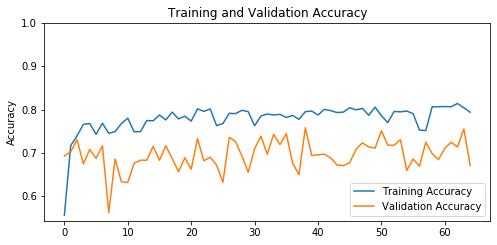

In [0]:

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()